# 요약

# 라이브러리

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, DenseNet121, Xception, NASNetMobile,
    ResNet50, VGG16
)

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# 모델

In [2]:
# 1. 데이터 준비
IMG_SIZE = 96  # 모델에 맞게 조정 가능
BATCH_SIZE = 32
DATA_PATH = "../../data/processed/02_kaggle_dataset/train"

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_gen = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [3]:
# 2. 전이 학습 모델 빌더 함수
def build_transfer_model(base_class, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base = base_class(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base.trainable = False  # 처음엔 동결

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [39]:
# 3. 사용할 아키텍처 목록
architectures = {
    'MobileNetV2': MobileNetV2,
    'EfficientNetB0': EfficientNetB0,
    'DenseNet121': DenseNet121,
    'Xception': Xception,
    'NASNetMobile': NASNetMobile,
    'ResNet50': ResNet50,
    'VGG16': VGG16
}

In [40]:
model_input_sizes = {
    'Xception': 299,
    'NASNetMobile': 224,
    'ResNet50': 224,
    'VGG16':   224
}

#     'MobileNetV2': 96,
#     'EfficientNetB0': 96,
#     'DenseNet121': 96,

## MobileNetV2

In [5]:
if __name__ == '__main__':
    name = 'MobileNetV2'
    print(f"Training with {name}...")
    model = build_transfer_model(architectures[name])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    model.save(f'results/models/{name}_drowsiness.h5')

    # 평가
    loss, acc = model.evaluate(val_gen)
    print(f"Validation accuracy: {acc:.4f}")


Training with MobileNetV2...
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
1200/1200 [==============================] - 103s 82ms/step - loss: 0.3694 - accuracy: 0.8340 - val_loss: 0.3709 - val_accuracy: 0.8680 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 97s 81ms/step - loss: 0.2655 - accuracy: 0.8933 - val_loss: 0.3613 - val_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 95s 79ms/step - loss: 0.2491 - accuracy: 0.9014 - val_loss: 0.3476 - val_accuracy: 0.8719 - lr: 1.0000e-04
Epoch 4/10
1200/1200 [==============================] - 166s 138ms/step - loss: 0.2341 - accuracy: 0.9071 - val_loss: 0.3819 - val_accuracy: 0.8597 - lr: 1.0000e-04
Epoch 5/10
1200/1200 [==============================] - 154s 128ms/step - loss: 0.2303 - accuracy: 0.9087 - val_loss: 0.3833 - val_accuracy: 0.8598 - lr: 1.0000e-04
Epoch 6/10
300/300 [==============================] - 15s 48ms/step - loss: 0.3522 - acc

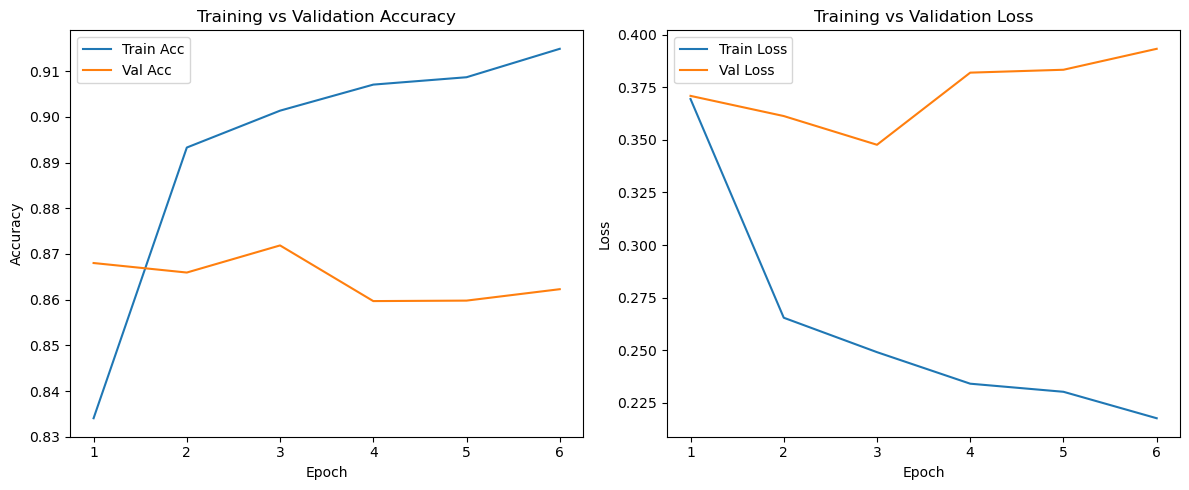

In [7]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Found 9600 images belonging to 2 classes.


301/301 [==============================] - 15s 49ms/step


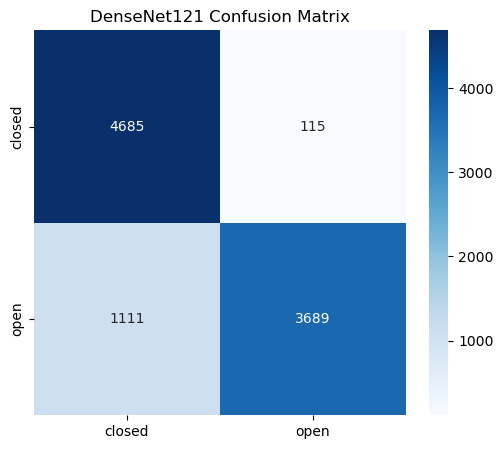

              precision  recall  f1-score  support
class                                             
closed             0.81    0.98      0.88     4800
open               0.97    0.77      0.86     4800
accuracy           0.87    0.87      0.87        0
macro avg          0.89    0.87      0.87     9600
weighted avg       0.89    0.87      0.87     9600


In [20]:
# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model
model = load_model('results/models/MobileNetV2_drowsiness.h5')

# 2) val_gen 재생성 (shuffle=False)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('DenseNet121 Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)

## EfficientNetB0(보류)

In [14]:
# if __name__ == '__main__':
#     name = 'EfficientNetB0'
#     print(f"Training with {name}...")
#     model = build_transfer_model(architectures[name])

#     history = model.fit(
#         train_gen,
#         validation_data=val_gen,
#         epochs=10,
#         callbacks=[
#             tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
#             tf.keras.callbacks.ReduceLROnPlateau(patience=2)
#         ]
#     )

#     model.save(
#     f'results/models/{name}_drowsiness.h5',
#     include_optimizer=False
# )

#     # 평가
#     loss, acc = model.evaluate(val_gen)
#     print(f"Validation accuracy: {acc:.4f}")


## DenseNet121

In [15]:
if __name__ == '__main__':
    name = 'DenseNet121'
    print(f"Training with {name}...")
    model = build_transfer_model(architectures[name])

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    model.save(f'results/models/{name}_drowsiness.h5')

    # 평가
    loss, acc = model.evaluate(val_gen)
    print(f"Validation accuracy: {acc:.4f}")


Training with DenseNet121...
29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/10
1200/1200 [==============================] - 88s 71ms/step - loss: 0.3155 - accuracy: 0.8693 - val_loss: 0.2107 - val_accuracy: 0.9125 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 83s 69ms/step - loss: 0.2108 - accuracy: 0.9198 - val_loss: 0.2139 - val_accuracy: 0.9092 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 82s 68ms/step - loss: 0.1951 - accuracy: 0.9257 - val_loss: 0.2218 - val_accuracy: 0.9035 - lr: 1.0000e-04
Epoch 4/10
300/300 [==============================] - 16s 53ms/step - loss: 0.2127 - accuracy: 0.9157
Validation accuracy: 0.9157


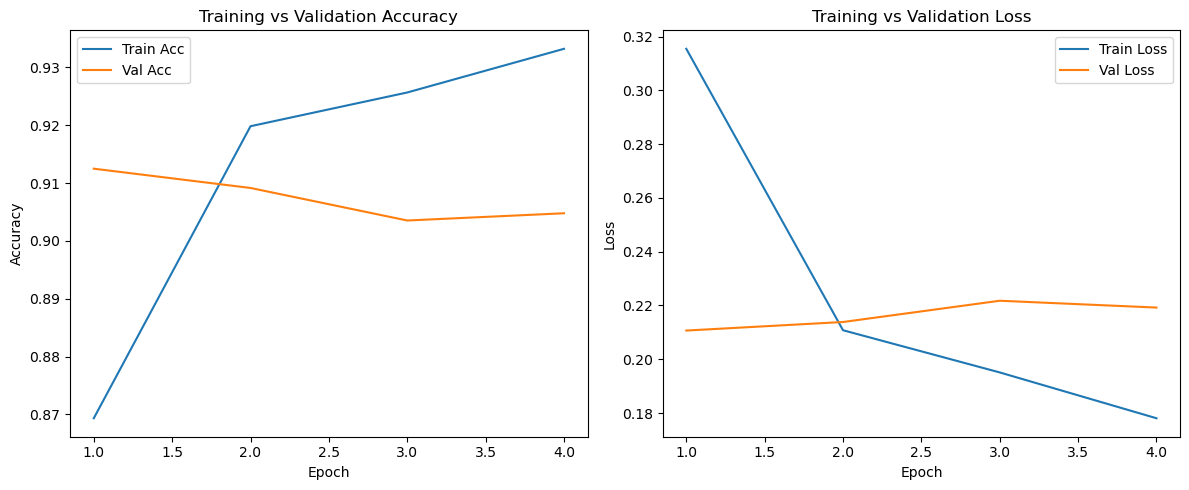

In [16]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 9600 images belonging to 2 classes.


301/301 [==============================] - 17s 53ms/step


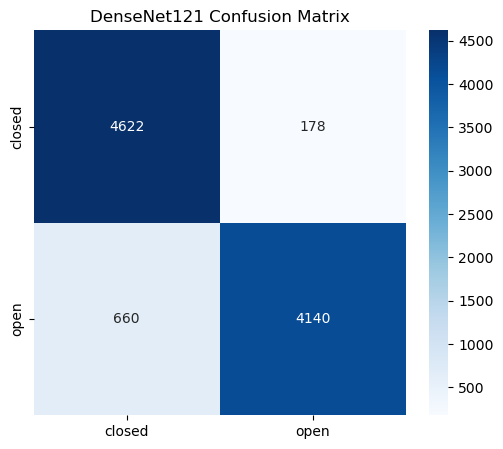

              precision  recall  f1-score  support
class                                             
closed             0.88    0.96      0.92     4800
open               0.96    0.86      0.91     4800
accuracy           0.91    0.91      0.91        0
macro avg          0.92    0.91      0.91     9600
weighted avg       0.92    0.91      0.91     9600


In [19]:
# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model
model = load_model('results/models/DenseNet121_drowsiness.h5')

# 2) val_gen 재생성 (shuffle=False)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('DenseNet121 Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)

## Xception

In [26]:
if __name__ == '__main__':
    name = 'Xception'
    print(f"Training with {name}...")

    # 1) 모델별 IMG_SIZE 설정
    IMG_SIZE = model_input_sizes[name]
    
    # 2) 제너레이터 재생성
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # 3) 모델 생성
    model = build_transfer_model(
        architectures[name],
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 4) 학습
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    # 5) 저장 (옵티마이저 제외)
    model.save(
        f'results/models/{name}_drowsiness.h5',
        include_optimizer=False
    )

    # 6) 평가
    loss, acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation accuracy: {acc:.4f}")

Training with Xception...
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
83683744/83683744 [==============================] - 3s 0us/step
Epoch 1/10
1200/1200 [==============================] - 940s 781ms/step - loss: 0.1769 - accuracy: 0.9370 - val_loss: 0.1969 - val_accuracy: 0.9233 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 1625s 1s/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.1983 - val_accuracy: 0.9235 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 1514s 1s/step - loss: 0.0977 - accuracy: 0.9641 - val_loss: 0.1850 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 4/10
1200/1200 [==============================] - 3192s 3s/step - loss: 0.0911 - accuracy: 0.9662 - val_loss: 0.1970 - val_accuracy: 0.9326 - lr: 1.0000e-04
Epoch 5/10
1200/1200 [==============================] - 4697s 4s/step - loss: 0.0920 - accuracy: 0.9661 - val_loss: 0.1912 - val_accuracy: 0.9350 - lr: 1.0000e-04
Epoch 6

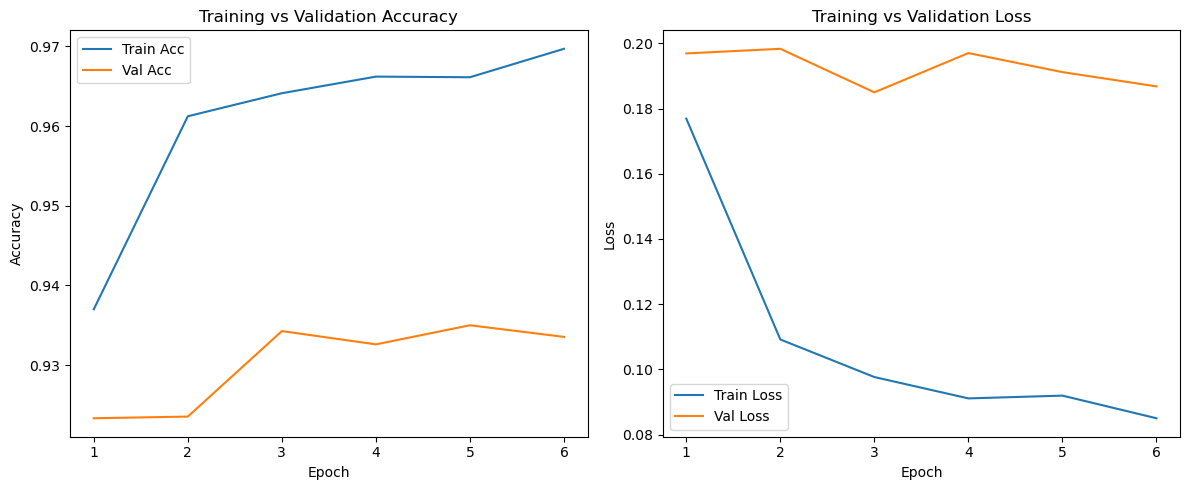

In [27]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 9600 images belonging to 2 classes.


301/301 [==============================] - 349s 1s/step


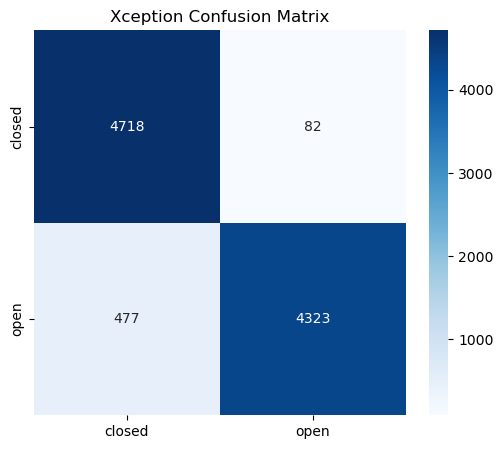

              precision  recall  f1-score  support
class                                             
closed             0.91    0.98      0.94     4800
open               0.98    0.90      0.94     4800
accuracy           0.94    0.94      0.94        0
macro avg          0.94    0.94      0.94     9600
weighted avg       0.94    0.94      0.94     9600


In [33]:
# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model

IMG_SIZE = 299
BATCH_SIZE = 32

model = load_model('results/models/Xception_drowsiness.h5')
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# 2) val_gen 재생성 (shuffle=False)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('Xception Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)

## NASNetMobile

In [29]:
if __name__ == '__main__':
    name = 'NASNetMobile'
    print(f"Training with {name}...")

    # 1) 모델별 IMG_SIZE 설정
    IMG_SIZE = model_input_sizes[name]
    
    # 2) 제너레이터 재생성
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # 3) 모델 생성
    model = build_transfer_model(
        architectures[name],
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 4) 학습
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    # 5) 저장 (옵티마이저 제외)
    model.save(
        f'results/models/{name}_drowsiness.h5',
        include_optimizer=False
    )

    # 6) 평가
    loss, acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation accuracy: {acc:.4f}")

Training with NASNetMobile...
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
19993432/19993432 [==============================] - 2s 0us/step
Epoch 1/10
1200/1200 [==============================] - 338s 277ms/step - loss: 0.2261 - accuracy: 0.9105 - val_loss: 0.2074 - val_accuracy: 0.9147 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 331s 276ms/step - loss: 0.1527 - accuracy: 0.9423 - val_loss: 0.2349 - val_accuracy: 0.9092 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 324s 270ms/step - loss: 0.1426 - accuracy: 0.9467 - val_loss: 0.2370 - val_accuracy: 0.9092 - lr: 1.0000e-04
Epoch 4/10
300/300 [==============================] - 65s 218ms/step - loss: 0.2078 - accuracy: 0.9181
Validation accuracy: 0.9181


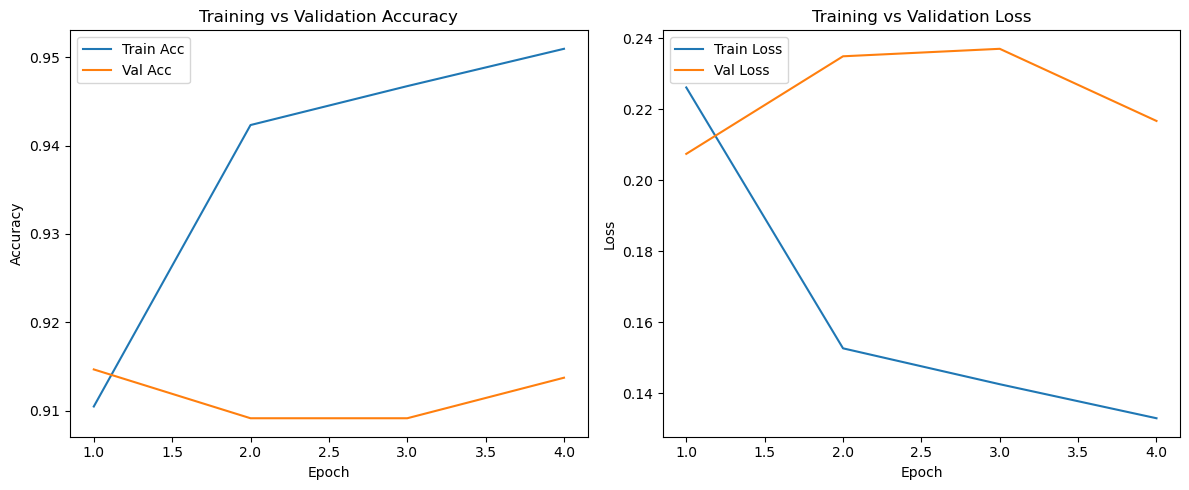

In [30]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 9600 images belonging to 2 classes.


301/301 [==============================] - 32s 101ms/step


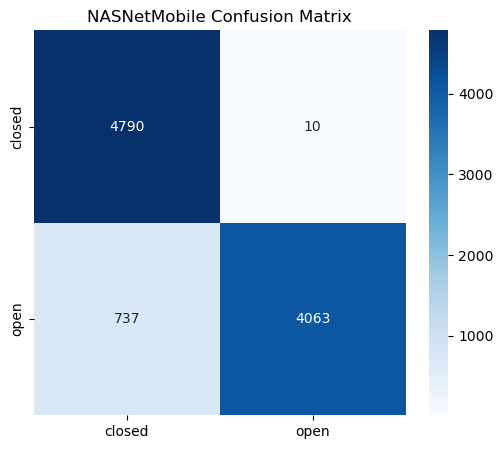

              precision  recall  f1-score  support
class                                             
closed             0.87    1.00      0.93     4800
open               1.00    0.85      0.92     4800
accuracy           0.92    0.92      0.92        0
macro avg          0.93    0.92      0.92     9600
weighted avg       0.93    0.92      0.92     9600


In [37]:
IMG_SIZE = 224

# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model
model = load_model('results/models/NASNetMobile_drowsiness.h5')
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# 2) val_gen 재생성 (shuffle=False)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('NASNetMobile Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)

## VGG16

In [41]:
if __name__ == '__main__':
    name = 'VGG16'
    print(f"Training with {name}...")

    # 1) 모델별 IMG_SIZE 설정
    IMG_SIZE = model_input_sizes[name]
    
    # 2) 제너레이터 재생성
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # 3) 모델 생성
    model = build_transfer_model(
        architectures[name],
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 4) 학습
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    # 5) 저장 (옵티마이저 제외)
    model.save(
        f'results/models/{name}_drowsiness.h5',
        include_optimizer=False
    )

    # 6) 평가
    loss, acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation accuracy: {acc:.4f}")

Training with VGG16...
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
1200/1200 [==============================] - 435s 360ms/step - loss: 0.6868 - accuracy: 0.5299 - val_loss: 0.6853 - val_accuracy: 0.5346 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 271s 226ms/step - loss: 0.6662 - accuracy: 0.5623 - val_loss: 0.6529 - val_accuracy: 0.5964 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 272s 226ms/step - loss: 0.6553 - accuracy: 0.5833 - val_loss: 0.6438 - val_accuracy: 0.6060 - lr: 1.0000e-04
Epoch 4/10
1200/1200 [==============================] - 266s 222ms/step - loss: 0.6450 - accuracy: 0.6056 - val_loss: 0.6412 - val_accuracy: 0.6008 - lr: 1.0000e-04
Epoch 5/10
1200/1200 [==============================] - 267s 222ms/step - loss: 0.6370 - accuracy: 0.6173 - val_loss: 0.6284 - val_accuracy: 0.7022 - lr: 1.0000e-04
Ep

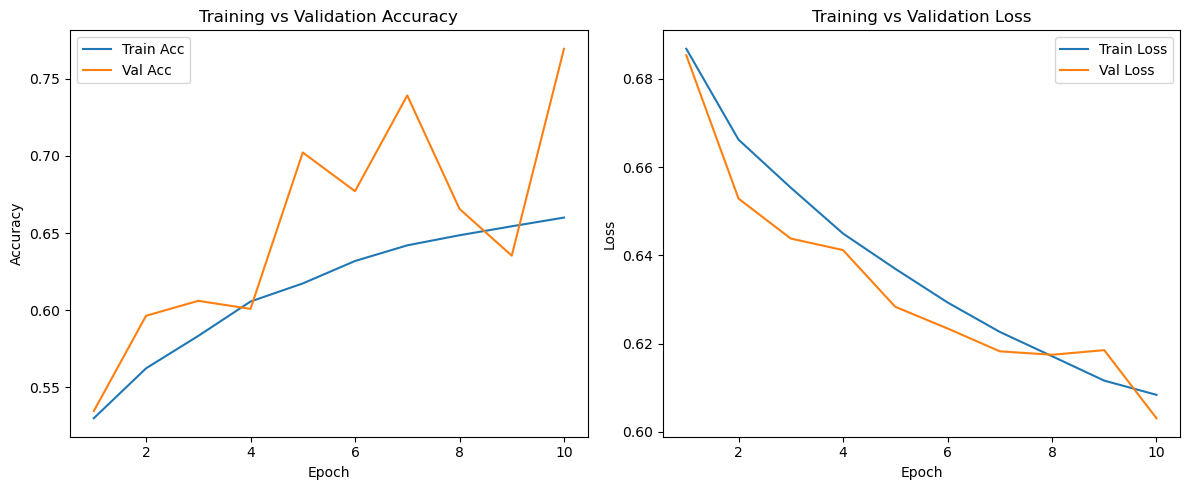

In [42]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 9600 images belonging to 2 classes.


301/301 [==============================] - 53s 177ms/step


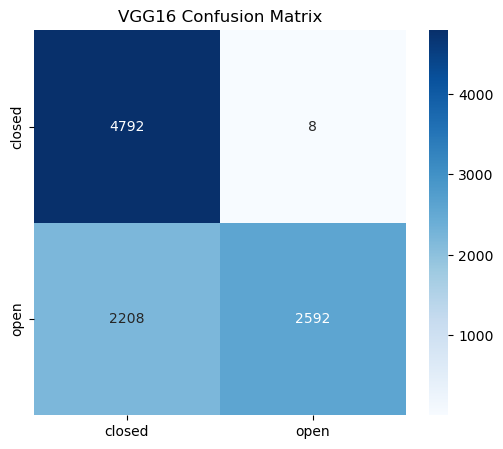

              precision  recall  f1-score  support
class                                             
closed             0.68    1.00      0.81     4800
open               1.00    0.54      0.70     4800
accuracy           0.77    0.77      0.77        0
macro avg          0.84    0.77      0.76     9600
weighted avg       0.84    0.77      0.76     9600


In [43]:
IMG_SIZE = 224

# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model
model = load_model('results/models/VGG16_drowsiness.h5')
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# 2) val_gen 재생성 (shuffle=False)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('VGG16 Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)

## ResNet50

In [44]:
if __name__ == '__main__':
    name = 'ResNet50'
    print(f"Training with {name}...")

    # 1) 모델별 IMG_SIZE 설정
    IMG_SIZE = model_input_sizes[name]
    
    # 2) 제너레이터 재생성
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        DATA_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # 3) 모델 생성
    model = build_transfer_model(
        architectures[name],
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 4) 학습
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2)
        ]
    )

    # 5) 저장 (옵티마이저 제외)
    model.save(
        f'results/models/{name}_drowsiness.h5',
        include_optimizer=False
    )

    # 6) 평가
    loss, acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation accuracy: {acc:.4f}")

Training with ResNet50...
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/10
1200/1200 [==============================] - 266s 220ms/step - loss: 0.7058 - accuracy: 0.5024 - val_loss: 0.6911 - val_accuracy: 0.5170 - lr: 1.0000e-04
Epoch 2/10
1200/1200 [==============================] - 261s 218ms/step - loss: 0.6975 - accuracy: 0.5063 - val_loss: 0.6898 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 3/10
1200/1200 [==============================] - 263s 219ms/step - loss: 0.6955 - accuracy: 0.5128 - val_loss: 0.6954 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/10
1200/1200 [==============================] - 261s 218ms/step - loss: 0.6948 - accuracy: 0.5146 - val_loss: 0.6950 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/10
300/300 [==============================] - 50s 168ms/step - loss: 0.6898 - accuracy: 0.6483
Validation accuracy: 0.6483


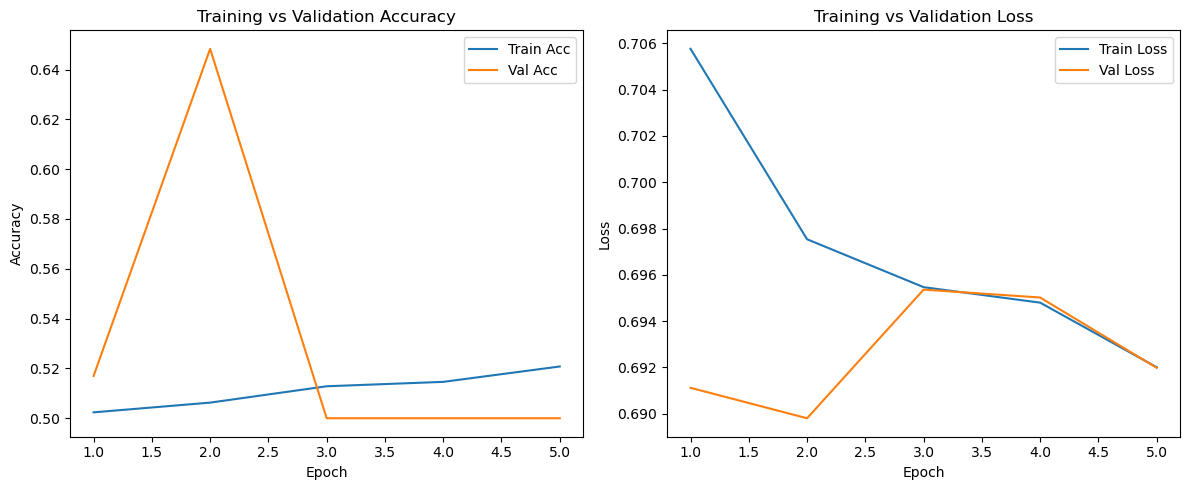

In [45]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# 정확도
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,    label='Train Acc')
plt.plot(epochs, val_acc,label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,    label='Train Loss')
plt.plot(epochs, val_loss,label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 9600 images belonging to 2 classes.


301/301 [==============================] - 51s 169ms/step


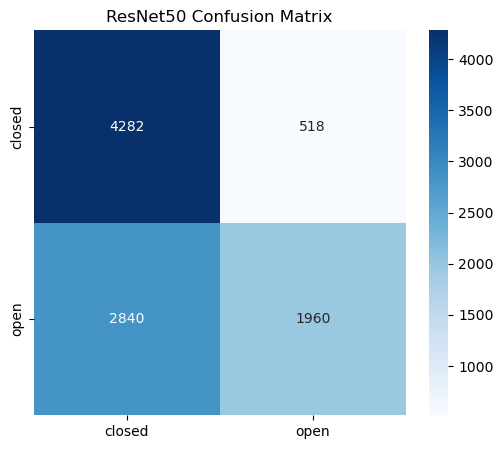

              precision  recall  f1-score  support
class                                             
closed             0.60    0.89      0.72     4800
open               0.79    0.41      0.54     4800
accuracy           0.65    0.65      0.65        0
macro avg          0.70    0.65      0.63     9600
weighted avg       0.70    0.65      0.63     9600


In [46]:
IMG_SIZE = 224

# 1) 모델 로드 혹은 재학습
from tensorflow.keras.models import load_model
model = load_model('results/models/ResNet50_drowsiness.h5')
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# 2) val_gen 재생성 (shuffle=False)
val_gen = datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='binary',
    subset='validation', shuffle=False
)

# 3) 예측 한 번만
steps = val_gen.samples // val_gen.batch_size + 1
y_pred_prob = model.predict(val_gen, steps=steps, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# 4) 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.show()

# 5) 리포트
report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)
df = pd.DataFrame(report).transpose()
df.index.name = 'class'
df['support'] = df['support'].astype(int)
pd.options.display.float_format = '{:0.2f}'.format
print(df)